<a href="https://colab.research.google.com/github/UselessEntity/langgraph_b4s1c/blob/master/LangGraph_b4s1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --quiet pip
!pip install --upgrade langchain langgraph langchain-core langchain-community langsmith langgraph-cli langchain-openai langchain-anthropic langchain-xai
!pip install --upgrade transformers datasets bitsandbytes
!pip install dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.4.4
    Uninstalling langsmith-0.4.4:
      Successfully uninstalled langsmith-0.4.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [langchain-community]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 150.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 166.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5

In [6]:
from google.colab import userdata
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_TOKEN"] = userdata.get("GROQ_TOKEN")
os.environ["LANGSMITH_TOKEN"] = userdata.get("LANGSMITH_TOKEN")
os.environ["GITHUB_TOKEN"] = userdata.get("GITHUB_TOKEN")

In [7]:
import os
import operator
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Dict, List

# I. State, Graph, Node đơn giản

In [8]:
# Một State đơn giản:
class GameState(TypedDict):
  game: str
  message: str
  message_2: str

# Tạo một node đơn giản:
def game_node(state: GameState) -> GameState: # Cái này là cập nhật & trả về trạng thái State sau khi cập nhật
  """Node đơn giản để thêm thông tin về games"""

  state['message'] = "Hey " + state['message'] + ", wanna play some games?"
  return state

def new_game(state: GameState) -> GameState:
  game = state['game']
  state['message_2'] = f"Let's play {game}!"
  return state

In [9]:
# Để là workflow, builder hay gì cũng đc, chỉ cần gắn giá trị đúng thôi
builder = StateGraph(GameState)

builder.add_node("Game", game_node) # Thêm node phải có 2 giá trị: Tên của node & node hiện tại
builder.add_node("Tekken_8", new_game)

builder.add_edge("Game", "Tekken_8")
builder.add_edge("Tekken_8", END)

In [10]:
# Thêm node khởi chạy & node cuối trình chạy của graph (chưa phải END node)
builder.set_entry_point("Game")
builder.set_finish_point("Tekken_8")

game_console = builder.compile() # Bắt buộc phải có compile thì sau đó mới chạy được code

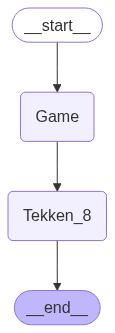

In [11]:
from IPython.display import Image, display
display(Image(game_console.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [12]:
result = game_console.invoke({"message": "Narrator", "game": "Tekken_8"}) # Chạy graph vừa được khởi tạo
print(result)

{'game': 'Tekken_8', 'message': 'Hey Narrator, wanna play some games?', 'message_2': "Let's play Tekken_8!"}


# Áp dụng làm một task với State đơn giản

In [13]:
# Tạo State
class Task1State(TypedDict):
  current_node: str
  name: str
  compliment: str

# Tạo ra node
def compliment_setup(state: Task1State) -> Task1State:
    """
    Tạo ra node đơn giản để thực hiện task
    Task ở đây: Tạo ra một Personalized Compliment Agent
    Input: {name: "Bob"}
    Output: "Bob, you're doing an amazing job at learning Langgraph!"
    """
    # print(state)
    name = state['name']
    state['compliment'] = f"Hey {state['name']}, you're doing an amazing job at learning Langgraph! Your curent node is: {state['current_node']}"
    # print(state)
    return state

# Tạo ra graph workflow chính
workflow = StateGraph(Task1State)

workflow.add_node("Compliment", compliment_setup)

workflow.set_entry_point("Compliment")

workflow.add_edge("Compliment", END)

new_compliment = workflow.compile()

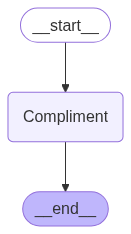

In [14]:
# Show flow dưới dạng graph
from IPython.display import Image, display
display(Image(new_compliment.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [15]:
# Invoke để chạy graph (vì đây là workflow), chứ ko phải chạy State
def invoke_result(input_data: dict) -> str:
  result = new_compliment.invoke(input_data)
  return result['compliment']

input = {"name": "Bob", "current_node": "Compliment"}
output = invoke_result(input)
print(output)

Hey Bob, you're doing an amazing job at learning Langgraph! Your curent node is: Compliment


# Nâng cao hơn chút (Graph với nhiều inputs, sử dụng nhiều State cùng lúc,...)

In [16]:
class AgeState(TypedDict):
  name: str
  values: list[int]
  operation: str
  result: str

def node_1(state: AgeState) -> AgeState:
  name = state['name']
  values = state['values']
  operation = state['operation']

  if operation == "+":
    result = sum(values)
  elif operation == "*":
    result = 1
    for num in values:
      result *= num
  else:
    result = 0

  state['result'] = f"Hi {state['name']}. You're {result} years old."
  return state

workflow = StateGraph(AgeState)

workflow.add_node("calculation_node", node_1)

workflow.set_entry_point("calculation_node")

workflow.add_edge("calculation_node", END)

human_age = workflow.compile()

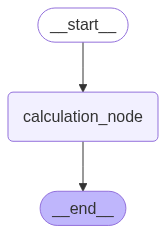

In [17]:
from IPython.display import Image, display
display(Image(human_age.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [18]:
input_data = {
    "name": "Jack",
    "values": [1,2,3,5],
    "operation": "*"
}

input_data_2 = {
    "name": "Jack",
    "values": [1,2,3,5],
    "operation": "+"
}

result = human_age.invoke(input_data_2)
print(result['result'])

Hi Jack. You're 11 years old.


In [19]:
class AgentState(TypedDict):
  name: str
  age: str
  result: str

In [20]:
def first_node(state: AgentState) -> AgentState:
  """Node đầu tiên trong chuỗi"""
  state['result'] = f"Hi {state['name']}."
  return state

def second_node(state: AgentState) -> AgentState:
  """Node thứ hai trong chuỗi"""
  state['result'] = state['result'] + f"You're {state['age']} years old." # Kết hợp hai node với nhau cùng lúc
  return state

In [21]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("first_node", first_node)
graph_builder.add_node("second_node", second_node)

graph_builder.set_entry_point("first_node")

graph_builder.add_edge("first_node", "second_node")
graph_builder.set_finish_point("second_node")

agent_graph = graph_builder.compile()

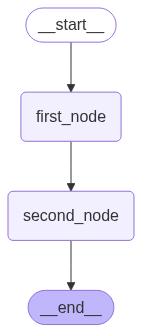

In [22]:
from IPython.display import Image, display
display(Image(agent_graph.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [23]:
result = agent_graph.invoke({"name": "Bob", "age": "21"})
print(result['result'])

Hi Bob.You're 21 years old.


In [24]:
class UserState(TypedDict):
  name: str
  age: str
  skills: str
  skills_list: List[str] # Add a new key for the input skills list

def name_node(state: UserState) -> UserState:
  name = state['name']
  state['skills'] = f"Hi {name}. Gladly meeting you here."
  return state

def age_node(state: UserState) -> UserState:
  age = state['age']
  state['skills'] = state['skills'] + f" You're {age} years old. You died young and got reincarnated to this new world."
  return state

def skill_node(state: UserState) -> UserState:
  # Use the skills_list from the input
  skills = ", ".join(state['skills_list'])
  state['skills'] = state['skills'] + f" You can choose these new skills: {skills} to start at this world."
  return state

isekai = StateGraph(UserState)

isekai.add_node("name_node", name_node)
isekai.add_node("age_node", age_node)
isekai.add_node("skill_node", skill_node)

isekai.set_entry_point("name_node")

isekai.add_edge("name_node", "age_node")
isekai.add_edge("age_node", "skill_node")
isekai.set_finish_point("skill_node")

isekai_character = isekai.compile()

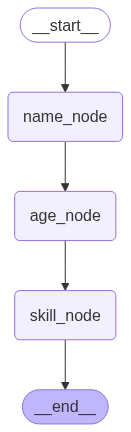

In [25]:
from IPython.display import Image, display
display(Image(isekai_character.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [26]:
input_data = {
    "name": "Jachiru",
    "age": "38",
    "skills_list": ["self_heal", "power_up_x100", "big_brain", "thief", "all_seeing"]
}

new_character = isekai_character.invoke(input_data)
print(new_character['skills'])

Hi Jachiru. Gladly meeting you here. You're 38 years old. You died young and got reincarnated to this new world. You can choose these new skills: self_heal, power_up_x100, big_brain, thief, all_seeing to start at this world.


# Router + conditional edges

In [27]:
class MathState(TypedDict):
  number_1: int
  number_2: int
  operation: str
  final_number: int

In [28]:
def addition(state: MathState) -> MathState:
  """
  Cộng 2 số với nhau
  """
  state['final_number'] = state['number_1'] + state['number_2']
  return state

def substraction(state: MathState) -> MathState:
  """ Trừ 2 số với nhau """
  state['final_number'] = state['number_1'] - state['number_2']
  return state

def decide_next_node(state: MathState) -> MathState:
  """ Node để chọn các node tiếp theo cho graph """
  if state['operation'] == "+":
    return "additional_node"
  elif state['operation'] == "-":
    return "subtraction_node"

graph = StateGraph(MathState)

graph.add_node("add_node", addition)
graph.add_node("subtract_node", substraction)
graph.add_node("router", lambda state:state) # Passthrough function

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "Plus": "add_node",
        "Minus": "subtract_node"
    }
)

graph.add_edge("add_node", END)
graph.add_edge("subtract_node", END)

app = graph.compile()

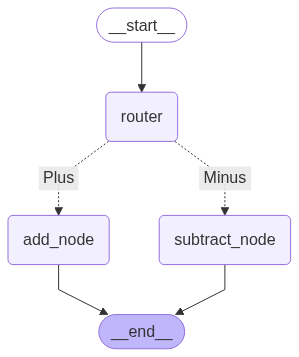

In [29]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))